<a href="https://colab.research.google.com/github/fmakkawi/Data201/blob/main/Project_2_DATA_201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()


Saving Electric_Vehicle_Population_Data.csv to Electric_Vehicle_Population_Data (1).csv


In [6]:
# ----------------------------------------------
# Data Loading and Cleaning
# Done by: Farah Makkawi
# ----------------------------------------------

import pandas as pd

# Load after uploading using files.upload()
df = pd.read_csv("Electric_Vehicle_Population_Data.csv", encoding="latin-1", on_bad_lines='skip')

df = df.rename(columns=lambda x: x.strip())

print("Column names in the dataset:")
print(df.columns.tolist())

# Filtes data to only contain WA
df = df[df["State"] == "WA"].copy()

df = df.dropna(subset=["Model Year", "Electric Range", "Base MSRP", "Electric Vehicle Type"])

#Presents the first 5 rows of the dataset
print("Dataset loaded and cleaned. New shape:", df.shape)
df.head()


Column names in the dataset:
['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']
Dataset loaded and cleaned. New shape: (263965, 17)


,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,WA1E2AFY8R,Thurston,Olympia,WA,98512.0,2024,AUDI,Q5 E,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,23.0,0.0,22.0,263239938,POINT (-122.90787 46.9461),PUGET SOUND ENERGY INC,5.306701e+10
1,WAUUPBFF4J,Yakima,Wapato,WA,98951.0,2018,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16.0,0.0,15.0,318160860,POINT (-120.42083 46.44779),PACIFICORP,5.307794e+10
2,1N4AZ0CP0F,King,Seattle,WA,98125.0,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,46.0,184963586,POINT (-122.30253 47.72656),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
3,WA1VAAGE5K,King,Kent,WA,98031.0,2019,AUDI,E-TRON,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,204.0,0.0,11.0,259426821,POINT (-122.17743 47.41185),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,7SAXCAE57N,Snohomish,Bothell,WA,98021.0,2022,TESLA,MODEL X,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,1.0,208182236,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,5.306105e+10


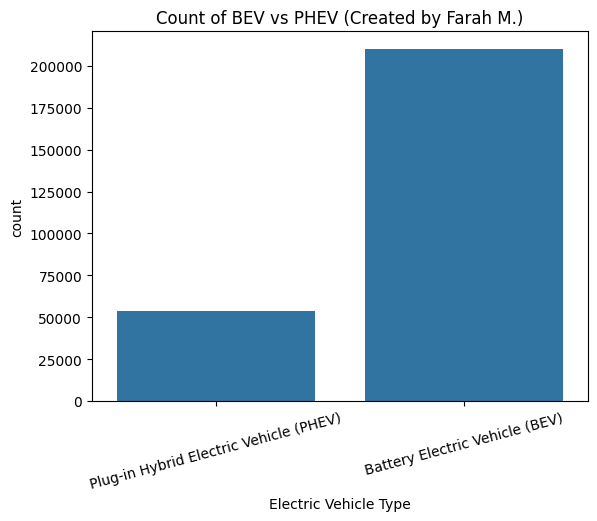

In [7]:
# ----------------------------------------------
# Basic EDA – Simple visualization
# Done by: Farah Makkawi
# ----------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x="Electric Vehicle Type")
plt.title("Count of BEV vs PHEV (Created by Farah M.)")
plt.xticks(rotation=15)
plt.show()

#The bar graph displays the number of BEV and PHEV in the data set.
#There are far more BEVs than PHEVs. 42,018 BEV and 10,775 PHEV.


In [ ]:
# EDA visualization : Top 10 manufacturers
# done by ousmane kandji

top_makes = df['Make'].value_counts().head(10).index
df_top = df[df['Make'].isin(top_makes)]

plt.figure(figsize=(12,6))
sns.boxplot(data=df_top, x='Make', y='Base MSRP')
plt.xticks(rotation=45)
plt.title('Price Distribution for Top 10 Manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.show()

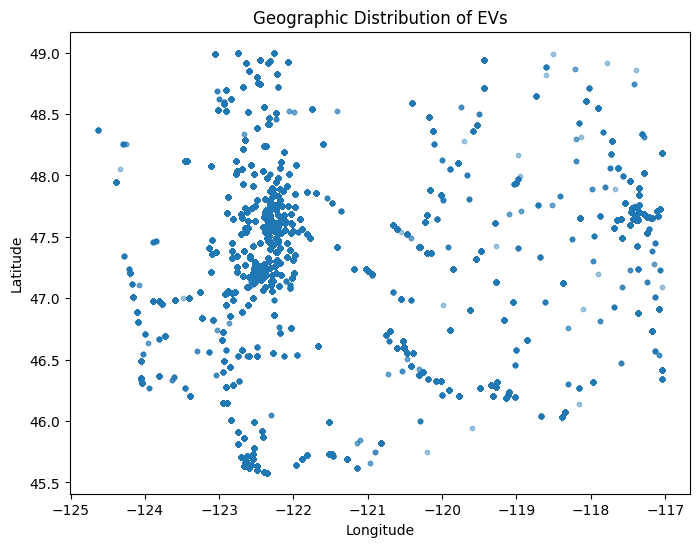

In [8]:
# Geographic Distribution of EVs (Latitude vs Longitude) scatterplot
# Ousmane kandji

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract longitude and latitude from the 'Vehicle Location' string
def extract_lat_lon(location_str):
    if pd.isna(location_str) or not isinstance(location_str, str):
        return None, None
    try:
        # Remove 'POINT (' and ')' and split by space
        parts = location_str.replace('POINT (', '').replace(')', '').split(' ')
        lon = float(parts[0])
        lat = float(parts[1])
        return lat, lon
    except:
        return None, None

# Apply the function to create new Latitude and Longitude columns
df['Latitude'], df['Longitude'] = zip(*df['Vehicle Location'].apply(extract_lat_lon))

# Drop rows where Latitude or Longitude couldn't be extracted
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

plt.figure(figsize=(8,6))
plt.scatter(
    df['Longitude'],
    df['Latitude'],
    alpha=0.4,
    s=10
)
plt.title('Geographic Distribution of EVs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [9]:
# ----------------------------------------------
# Logistic Regression Model
# Done by: Farah Makkawi
# ----------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Turn EV type into binary: 1 = BEV, 0 = PHEV
df["is_bev"] = (df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)").astype(int)

# Select input features
#X is used to predict EV type
X = df[["Model Year", "Electric Range", "Base MSRP"]]
#Y is the target variable
y = df["is_bev"]

# Split dataset
#80% training, 20% testing
#stratify=y ensures the proportion of BEV/PHEV is the same in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize values
#Standardizes the features so they all have the same scale.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
#max_iter=1000 ensures convergence if the default 100 iterations is not enough.
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

#Jonathan & Farah (This predict classes. We also need Class Probability)
# Predict
y_pred = log_model.predict(X_test_scaled)

# Jonathan - Predict class probabilities: 1 = BEV, 0 = PHEV
y_prob = log_model.predict_proba(X_test_scaled)
print("Class order in predict_proba:", log_model.classes_)
print("\nPredicted Class Probabilities (first 10 rows):")
print(y_prob[:10])


# Show results and Evaluating the Model
print("\nLogistic Regression Accuracy (Farah):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Class order in predict_proba: [0 1]

Predicted Class Probabilities (first 10 rows):
[[0.30618135 0.69381865]
 [0.14521659 0.85478341]
 [0.20227939 0.79772061]
 [0.16684379 0.83315621]
 [0.2082026  0.7917974 ]
 [0.06836703 0.93163297]
 [0.14521659 0.85478341]
 [0.23372127 0.76627873]
 [0.17410625 0.82589375]
 [0.05837834 0.94162166]]

Logistic Regression Accuracy (Farah): 0.8065994847704198

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.07      0.13     10775
           1       0.81      0.99      0.89     42017

    accuracy                           0.81     52792
   macro avg       0.79      0.53      0.51     52792
weighted avg       0.80      0.81      0.74     52792

Confusion Matrix:
 [[  787  9988]
 [  222 41795]]


In [10]:
# ----------------------------------------------
# Compare One-Vs-All (OvR) and One-Vs-One (OvO)
# Done by: Jonathan Rodriguez
# ----------------------------------------------

#Theses lines of code import One-vs-One classifier (OvO) and One-vs-Rest(OvR)
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#One-vs-Rest (OvR) logistic regression (BEV vs not BEV [Since BEV is 1])
ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
ovr_model.fit

#One-vs-One (OvO) comapres BEV vs PHEV
ovo_model = OneVsOneClassifier(LogisticRegression(max_iter=1000))
ovo_model.fit

#Fitting models
#Both models are trained on the scaled training data.
#After this, they can predict class labels for new data.
ovr_model.fit(X_train_scaled, y_train)
ovo_model.fit(X_train_scaled, y_train)

#Evaluating Accuracy
#.score() computes the accuracy on the test set.
#Accuracy = proportion of correct predictions.

ovr_accuracy = ovr_model.score(X_test_scaled, y_test)
ovo_accuracy = ovo_model.score(X_test_scaled, y_test)

print("OvR Accuracy\n", ovr_accuracy)
print("OvO Accuracy\n", ovo_accuracy)


OvR Accuracy
 0.8065994847704198
OvO Accuracy
 0.8065994847704198
